In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools
from utils import *
import shap
pd.set_option("display.max_rows",100)

C:\Users\ghibl\anaconda3\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\ghibl\anaconda3\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\ghibl\anaconda3\Lib\site-packages\shap\utils\_clustering.py:62: NumbaDeprecationWarning: The 'nopython' key

In [3]:
dataset_df = pd.read_csv(r"C:\Users\ghibl\ICR\data\input\all_features.csv")
dataset_df.drop("Id",axis = 1, inplace = True)

In [4]:
X_df = dataset_df.drop("Class",axis =1)
y_df = dataset_df["Class"].copy()


In [5]:
y_df.unique()

array([1, 0], dtype=int64)

In [6]:
dtrain = lgb.Dataset(X_df.values, label = y_df.values)
y_true = dtrain.get_label()
y_pred = np.array([0.5]*len(y_true))
balanced_logloss(y_pred,y_true)


0.6931471805599452

In [7]:
fs = X_df.columns
scores= []
evals_result = {}
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

for tr_idx, va_idx in skf.split(X_df, y_df):
    X_train, X_valid = X_df.iloc[tr_idx], X_df.iloc[va_idx]
    y_train, y_valid = y_df.iloc[tr_idx], y_df.iloc[va_idx]
    
    dtrain = lgb.Dataset(X_train.values, label = y_train.values)
    dvalid = lgb.Dataset(X_valid.values, label = y_valid.values)

    evals_result = {}
    params = {'metric':'custom',
              'objective':'binary',
              'verbosity':-1,
              'random_state' : 42, 
              'learning_rate': 0.1,
              'early_stopping_round':20
             }

    callbacks = [lgb.early_stopping(20, verbose=0), lgb.log_evaluation(period=10)]
    model = lgb.train(params,
                      dtrain, 
                      num_boost_round = 500,
                      valid_sets = [dtrain,dvalid],
                      valid_names = ['train','valid'],
                      feval = original_balanced_logloss_metric,
                      callbacks = callbacks
                     )
    score = model.best_score['valid']['balanced_logloss']
    scores.append(score)
    print(f'balanced_logloss:{score:.4f}')
score_cv = np.mean(scores)
print(score_cv)

[10]	train's balanced_logloss: 0.596008	valid's balanced_logloss: 0.631429
[20]	train's balanced_logloss: 0.549676	valid's balanced_logloss: 0.603006
[30]	train's balanced_logloss: 0.527021	valid's balanced_logloss: 0.592331
[40]	train's balanced_logloss: 0.515497	valid's balanced_logloss: 0.584424
[50]	train's balanced_logloss: 0.509649	valid's balanced_logloss: 0.579143
[60]	train's balanced_logloss: 0.506547	valid's balanced_logloss: 0.576285
[70]	train's balanced_logloss: 0.504938	valid's balanced_logloss: 0.574352
[80]	train's balanced_logloss: 0.504071	valid's balanced_logloss: 0.571081
[90]	train's balanced_logloss: 0.50366	valid's balanced_logloss: 0.568758
[100]	train's balanced_logloss: 0.50344	valid's balanced_logloss: 0.566465
[110]	train's balanced_logloss: 0.503325	valid's balanced_logloss: 0.563622
[120]	train's balanced_logloss: 0.503266	valid's balanced_logloss: 0.562319
[130]	train's balanced_logloss: 0.503237	valid's balanced_logloss: 0.559995
[140]	train's balanced_

In [40]:
fs = X_df.columns
scores= []
evals_results = []
models = []
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

for tr_idx, va_idx in skf.split(X_df, y_df):
    X_train, X_valid = X_df.iloc[tr_idx], X_df.iloc[va_idx]
    y_train, y_valid = y_df.iloc[tr_idx], y_df.iloc[va_idx]
    
    dtrain = lgb.Dataset(X_train, label = y_train)
    dvalid = lgb.Dataset(X_valid, label = y_valid)

    evals_result = {}
    params = {'metric':'custom',
              'objective':'custom',
              'verbosity':-1,
              'random_state' : 42, 
              'learning_rate': 0.1,
              'early_stopping_round':20
             }

    callbacks = [lgb.early_stopping(20, verbose=0), lgb.log_evaluation(period=10),lgb.record_evaluation(evals_result)]
    model = lgb.train(params,
                      dtrain, 
                      num_boost_round = 500,
                      valid_sets = [dtrain,dvalid],
                      valid_names = ['train','valid'],
                      feval = original_balanced_logloss_metric,
                      fobj = original_binary_logloss_objective,
                      callbacks = callbacks
                     )
    models.append(model)
    evals_results.append(evals_result)
    score = model.best_score['valid']['balanced_logloss']
    scores.append(score)
    print(f'balanced_logloss:{score:.4f}')
score_cv = np.mean(scores)
print(score_cv)

[10]	train's balanced_logloss: 0.35393	valid's balanced_logloss: 0.494908
[20]	train's balanced_logloss: 0.192145	valid's balanced_logloss: 0.383373
[30]	train's balanced_logloss: 0.106155	valid's balanced_logloss: 0.349127
[40]	train's balanced_logloss: 0.0558039	valid's balanced_logloss: 0.360636
[50]	train's balanced_logloss: 0.0297802	valid's balanced_logloss: 0.35916
balanced_logloss:0.3471
[10]	train's balanced_logloss: 0.340819	valid's balanced_logloss: 0.438081
[20]	train's balanced_logloss: 0.189033	valid's balanced_logloss: 0.383351
[30]	train's balanced_logloss: 0.106254	valid's balanced_logloss: 0.389613
[40]	train's balanced_logloss: 0.0586389	valid's balanced_logloss: 0.382897
[50]	train's balanced_logloss: 0.0312646	valid's balanced_logloss: 0.367835
[60]	train's balanced_logloss: 0.0165526	valid's balanced_logloss: 0.388008
[70]	train's balanced_logloss: 0.00875119	valid's balanced_logloss: 0.413369
balanced_logloss:0.3678
[10]	train's balanced_logloss: 0.337247	valid's

# 0.3859677412601033

In [20]:
fig = make_subplots(rows = 2,cols = 2,
                    subplot_titles=("fold1", "fold2", "fold3", "fold4"))
tuples = [(1,1),(1,2),(2,1),(2,2)]
for i in range(len(evals_results)):
    train_log = evals_results[i]['train']['balanced_logloss'] 
    eval_log = evals_results[i]['valid']['balanced_logloss'] 
    x = np.arange(1,1+len(train_log))
    fig.add_trace(go.Scatter(x = x, y = train_log,mode = 'lines',name = 'train'),
                 row = tuples[i][0],col = tuples[i][1])
    fig.add_trace(go.Scatter(x = x, y = eval_log,mode = 'lines',name = 'eval'),
                 row = tuples[i][0],col = tuples[i][1])
fig.update_layout(
    title = "fold1, fold2, fold3, fold4"
)

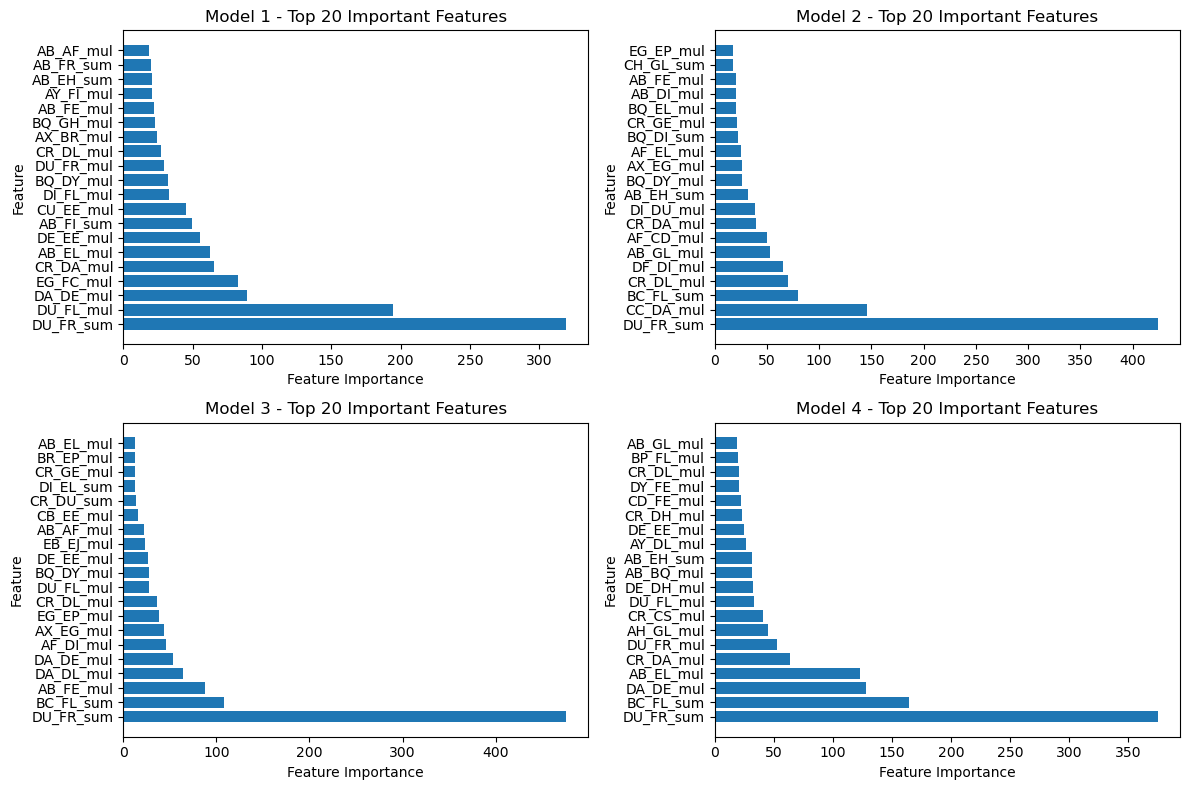

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


# 各モデルに対して特徴量の重要度をプロット
for i, model in enumerate(models):
    # 重要度の取得
    importance = model.feature_importance(importance_type='gain')
    # 特徴量の名前の取得
    feature_names = model.feature_name()

    # 重要度を降順にソートして上位20個を選択
    top_features = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)[:20]
    # 上位20個の特徴量とその重要度を取得
    top_feature_names = [feat[0] for feat in top_features]
    top_feature_importance = [feat[1] for feat in top_features]

    # サブプロットにプロット
    ax = axes[i // 2, i % 2]  # サブプロットの位置を指定
    ax.barh(range(len(top_feature_names)), top_feature_importance, align='center')
    ax.set_yticks(range(len(top_feature_names)))
    ax.set_yticklabels(top_feature_names)
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Feature')
    ax.set_title(f'Model {i+1} - Top 20 Important Features')

# サブプロット間のスペースを調整
plt.tight_layout()

# プロットの表示
plt.show()

In [22]:
evaluate(X_df.columns,X_df,y_df)

0.3859677412601033

In [23]:
len(model.feature_importance())

3151

In [24]:
feature_importances = []
feature_names = []
features_df = pd.DataFrame()
for i,model in enumerate(models):
    feature_importance = model.feature_importance(importance_type='gain')
    feature_importances.append(feature_importance)
    features_df[f"Fold{i+1}"] = feature_importance
feature_name = model.feature_name()
feature_importances_array = np.array(feature_importances)
mean_importances = np.mean(feature_importances,axis = 0)
std_importances = np.std(feature_importances,axis = 0)
coefficient_of_variation = std_importances / mean_importances

features_df["Mean"] = mean_importances
features_df["Std"] = std_importances
features_df["CV"] = coefficient_of_variation
features_df.set_axis(feature_name,axis = 0, inplace = True)


C:\Users\ghibl\AppData\Local\Temp\ipykernel_7056\3122687559.py:12: RuntimeWarning:

invalid value encountered in divide

C:\Users\ghibl\AppData\Local\Temp\ipykernel_7056\3122687559.py:17: FutureWarning:

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead



In [25]:
features_df["CV"].notnull().sum()

1342

In [26]:
features_df_nonull = features_df.dropna(how = "any")

In [27]:
features_df_nonull.sort_values(by ="CV", ascending = True).head(30)

,Fold1,Fold2,Fold3,Fold4,Mean,Std,CV
DU_FR_sum,319.412841,424.188562,475.663838,375.287673,398.638229,57.895756,0.145234
BQ_DY_mul,32.499933,26.327416,27.277645,10.038857,24.035963,8.416012,0.350142
AB_AF_mul,18.800375,5.737046,22.489401,14.769663,15.449121,6.236636,0.403689
CR_DL_mul,27.487558,70.449392,36.422439,20.247628,38.651754,19.231554,0.497560
BC_FL_sum,17.887690,79.782726,108.735059,164.338527,92.686000,52.803737,0.569706
BQ_GH_mul,23.119096,17.166317,0.037055,18.172643,14.623778,8.717825,0.596140
AB_EH_sum,20.614034,32.100254,0.000000,31.592051,21.076585,13.005121,0.617041
CR_DA_mul,65.499368,39.821721,0.000000,63.617571,42.234665,26.401062,0.625104
CD_GL_mul,10.165900,17.339835,0.000000,15.319409,10.706286,6.711957,0.626917
AY_DL_mul,7.505700,10.794710,5.913060,26.304021,12.629373,8.088925,0.640485


In [28]:
selected = list(features_df_nonull.index)
len(selected)

1342

In [29]:
evaluate(selected,X_df,y_df)

0.3837436191854227

In [41]:
X_df_selected = X_df[selected]
scores= []
evals_results = []
models = []
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

for tr_idx, va_idx in skf.split(X_df_selected, y_df):
    X_train, X_valid = X_df_selected.iloc[tr_idx], X_df_selected.iloc[va_idx]
    y_train, y_valid = y_df.iloc[tr_idx], y_df.iloc[va_idx]
    
    dtrain = lgb.Dataset(X_train, label = y_train)
    dvalid = lgb.Dataset(X_valid, label = y_valid)

    evals_result = {}
    params = {'metric':'custom',
              'objective':'custom',
              'verbosity':-1,
              'random_state' : 42, 
              'learning_rate': 0.1,
              'early_stopping_round':20
             }

    callbacks = [lgb.early_stopping(20, verbose=0), lgb.log_evaluation(period=10),lgb.record_evaluation(evals_result)]
    model = lgb.train(params,
                      dtrain, 
                      num_boost_round = 500,
                      valid_sets = [dtrain,dvalid],
                      valid_names = ['train','valid'],
                      feval = original_balanced_logloss_metric,
                      fobj = original_binary_logloss_objective,
                      callbacks = callbacks
                     )
    models.append(model)
    evals_results.append(evals_result)
    score = model.best_score['valid']['balanced_logloss']
    scores.append(score)
    print(f'balanced_logloss:{score:.4f}')
score_cv = np.mean(scores)
print(score_cv)

[10]	train's balanced_logloss: 0.35393	valid's balanced_logloss: 0.494908
[20]	train's balanced_logloss: 0.192145	valid's balanced_logloss: 0.383373
[30]	train's balanced_logloss: 0.106155	valid's balanced_logloss: 0.349127
[40]	train's balanced_logloss: 0.0549225	valid's balanced_logloss: 0.357168
[50]	train's balanced_logloss: 0.029817	valid's balanced_logloss: 0.344133
[60]	train's balanced_logloss: 0.0156777	valid's balanced_logloss: 0.347932
[70]	train's balanced_logloss: 0.00837697	valid's balanced_logloss: 0.359577
balanced_logloss:0.3428
[10]	train's balanced_logloss: 0.340819	valid's balanced_logloss: 0.438081
[20]	train's balanced_logloss: 0.189033	valid's balanced_logloss: 0.383351
[30]	train's balanced_logloss: 0.106254	valid's balanced_logloss: 0.389613
[40]	train's balanced_logloss: 0.0586389	valid's balanced_logloss: 0.382897
[50]	train's balanced_logloss: 0.0312646	valid's balanced_logloss: 0.367835
[60]	train's balanced_logloss: 0.0167553	valid's balanced_logloss: 0.37

In [33]:
fig = make_subplots(rows = 2,cols = 2,
                    subplot_titles=("fold1", "fold2", "fold3", "fold4"))
tuples = [(1,1),(1,2),(2,1),(2,2)]
for i in range(len(evals_results)):
    train_log = evals_results[i]['train']['balanced_logloss'] 
    eval_log = evals_results[i]['valid']['balanced_logloss'] 
    x = np.arange(1,1+len(train_log))
    fig.add_trace(go.Scatter(x = x, y = train_log,mode = 'lines',name = 'train'),
                 row = tuples[i][0],col = tuples[i][1])
    fig.add_trace(go.Scatter(x = x, y = eval_log,mode = 'lines',name = 'eval'),
                 row = tuples[i][0],col = tuples[i][1])
fig.update_layout(
    title = "fold1, fold2, fold3, fold4"
)

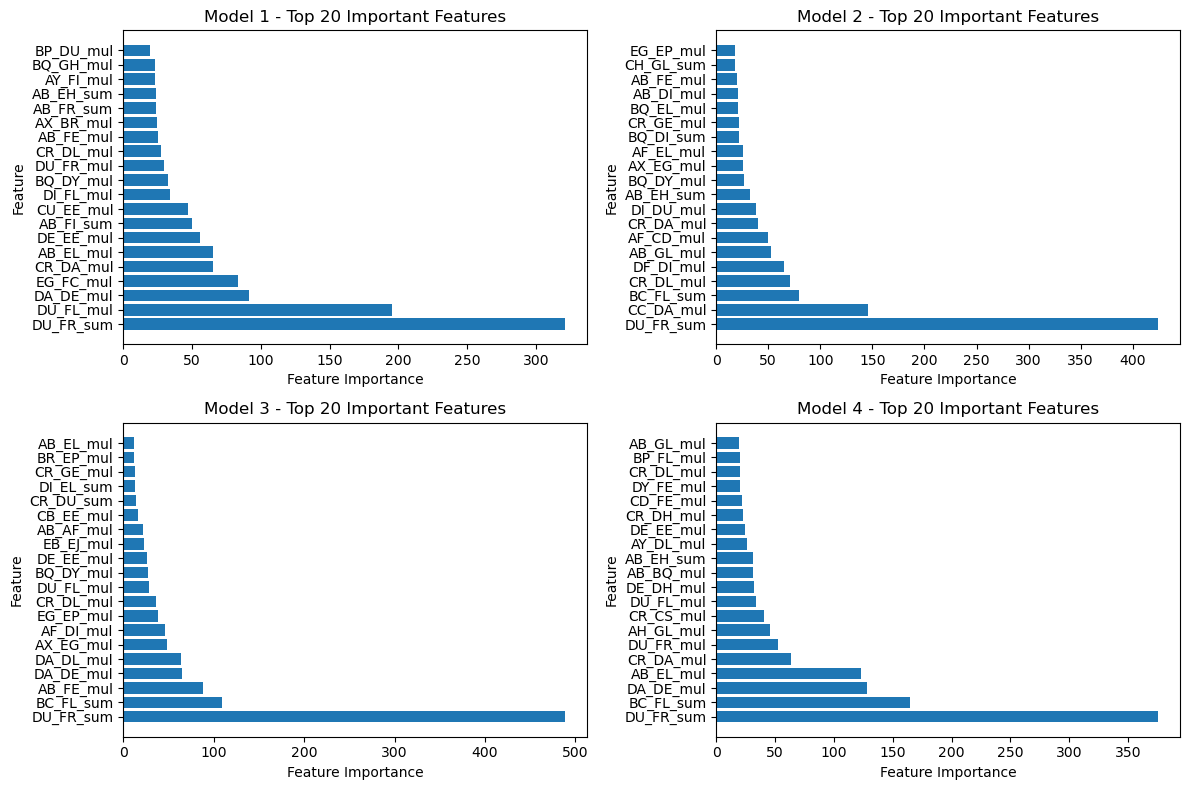

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


# 各モデルに対して特徴量の重要度をプロット
for i, model in enumerate(models):
    # 重要度の取得
    importance = model.feature_importance(importance_type='gain')
    # 特徴量の名前の取得
    feature_names = model.feature_name()

    # 重要度を降順にソートして上位20個を選択
    top_features = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)[:20]
    # 上位20個の特徴量とその重要度を取得
    top_feature_names = [feat[0] for feat in top_features]
    top_feature_importance = [feat[1] for feat in top_features]

    # サブプロットにプロット
    ax = axes[i // 2, i % 2]  # サブプロットの位置を指定
    ax.barh(range(len(top_feature_names)), top_feature_importance, align='center')
    ax.set_yticks(range(len(top_feature_names)))
    ax.set_yticklabels(top_feature_names)
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Feature')
    ax.set_title(f'Model {i+1} - Top 20 Important Features')

# サブプロット間のスペースを調整
plt.tight_layout()

# プロットの表示
plt.show()

In [35]:
feature_importances = []
feature_names = []
features_df = pd.DataFrame()
for i,model in enumerate(models):
    feature_importance = model.feature_importance(importance_type='gain')
    feature_importances.append(feature_importance)
    features_df[f"Fold{i+1}"] = feature_importance
feature_name = model.feature_name()
feature_importances_array = np.array(feature_importances)
mean_importances = np.mean(feature_importances,axis = 0)
std_importances = np.std(feature_importances,axis = 0)
coefficient_of_variation = std_importances / mean_importances

features_df["Mean"] = mean_importances
features_df["Std"] = std_importances
features_df["CV"] = coefficient_of_variation
features_df.set_axis(feature_name,axis = 0, inplace = True)


C:\Users\ghibl\AppData\Local\Temp\ipykernel_7056\3122687559.py:17: FutureWarning:

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead



In [36]:
features_df_nonull = features_df.dropna(how = "any")

In [37]:
features_df_nonull.sort_values(by ="CV", ascending = True).head(30)

,Fold1,Fold2,Fold3,Fold4,Mean,Std,CV
DU_FR_sum,321.047023,424.189524,488.305838,375.287673,402.207515,61.660022,0.153304
BQ_DY_mul,32.500142,26.327416,27.282869,10.038857,24.037321,8.416568,0.350146
AB_AF_mul,18.800375,5.737164,22.489401,14.769663,15.449151,6.236590,0.403685
CR_DL_mul,27.487813,70.449392,36.422439,20.247628,38.651818,19.231517,0.497558
BC_FL_sum,18.944043,79.782726,108.735059,164.338527,92.950089,52.430307,0.564069
BQ_GH_mul,23.119096,17.166317,0.037055,18.172643,14.623778,8.717825,0.596140
AB_EH_sum,23.563674,32.100261,0.000000,31.592051,21.813996,13.041562,0.597853
CR_DA_mul,65.499376,39.821721,0.000000,63.617571,42.234667,26.401064,0.625104
CD_GL_mul,10.165900,17.339835,0.000000,15.319409,10.706286,6.711957,0.626917
AY_DL_mul,7.505702,10.794710,5.913060,26.304021,12.629373,8.088925,0.640485
